In [1]:
from memoization import memoize_to_folder

In [669]:
from scapy.all import *
import sys
import numpy as np
import os

KEYLEN=8

@memoize_to_folder('memo/pcaps2')
def read_pcap2(out_dir):
    pcfs = [os.path.join(out_dir, 'moongen', 'moongen_in.pcap'),
            os.path.join(out_dir, 'moongen', 'moongen_out.pcap')]
    
    n_sets = [0]
    n_misses = [0]
    n_gets = [0]
    n_values = [0]
    gets = defaultdict(list)
    vals = defaultdict(list)
    
    for pcf in pcfs:
        f = open(pcf, 'rb')
        print("Reading {}".format(pcf))
        pcap=dpkt.pcap.Reader(f)
        for ts, buf in pcap:
            try:
                eth=dpkt.ethernet.Ethernet(buf)
                ip=eth.data
                tcp = ip.data
                spkt = tcp.data
            except Exception as e:
                print("Exception parsing packet {} : {}".format(buf, e))
                continue

            try: 
                get_start = spkt.find(b'get ')
                if get_start >= 0:
                    key = spkt[:2] + spkt[get_start+4:get_start+4+KEYLEN]
                    gets[key].append(ts)
                    n_gets[0] += 1
                    if n_gets[0] % 5000 == 0:
                        print('{}th get'.format(n_gets[0]))
                    continue
                val_start = spkt.find(b'VALUE ')
                if val_start >= 0:
                    key = spkt[:2] + spkt[val_start+6:val_start+6+KEYLEN]
                    vals[key].append(ts)
                    n_values[0] += 1
                    if n_values[0] % 5000 == 0:
                        print("{}th value".format(n_values[0]))
                    continue
                if b'set ' in spkt:
                    n_sets[0] += 1
                    if n_sets[0] % 2000 == 0:
                        print('{}th set'.format(n_sets[0]))
                elif b'STORED' in spkt:
                    continue
                elif b'END' in spkt:
                    n_misses[0] += 1
                else:
                    print('Unknown packet load: {}'.format(spkt))
            except AttributeError as e:
                print("Exception reading payload from {}: {}".format(buf, e))
        
    print("Got {} sets".format(n_sets[0]))
    print("Got {} values".format(n_values[0]))
    
    print("Got {} explicit misses".format(n_misses[0]))
    print("Read pcap file")
    return gets, vals

def read_rate_file(out_dir):
    ratefile = os.path.join(out_dir, 'pktgen.log')
    try:
        with open(ratefile) as f:
            ratestr = f.read()
    except:
        return 0
    if not ratestr.startswith('Rate: '):
        raise Exception("Could not read rate string")
    rate = int(ratestr.strip("Rate: "))
    return rate

def read_experiment(directory, recalculate=False):
    print( "Reading from directory {}".format(directory))
    return read_pcap2(directory, __recalculate=recalculate), read_rate_file(directory)

In [336]:
import itertools

def best_drop_tds(vtimes, gtimes, both_drops=0):
    vtimes = np.array(vtimes)
    gtimes = np.array(gtimes)
    lendiff = len(gtimes) - len(vtimes)
    maxlen = max(len(gtimes), len(vtimes))
    minlen = min(len(gtimes), len(vtimes))
    
    n_gdrops = max(-lendiff, 0)
    n_vdrops = max(lendiff, 0)
    
    if n_gdrops == 0 and n_vdrops == 0:
        tdiffs = vtimes - gtimes
        tds = []
        for td, gd in zip(tdiffs, gtimes):
            if not np.isnan(td) and td > 0:
                tds.append((gd, td))
        return tds        
    
    if n_gdrops != 0:
        print( "Missing GET")
        
        drop_locs = []
        max_drop = 0
        
        for n_g in range(n_gdrops):
            v_cut = vtimes[: minlen + n_g + 1]
            min_std = None
            min_std_drop_locs = None
            
            for i in range(max_drop, len(v_cut)):
                this_drop_locs = drop_locs[:]
                this_drop_locs.append(i)
                
                this_gtimes = gtimes[:]
                for drop_loc in this_drop_locs:
                    this_gtimes = np.insert(this_gtimes, drop_loc, np.nan)
                
                tdiffs = v_cut - this_gtimes
                tdiffs = tdiffs[~np.isnan(tdiffs)]
                if any(tdiffs < 0):
                    continue
                this_std = np.std(tdiffs)
                
                if min_std is None or this_std < min_std:
                    min_std = this_std
                    min_std_drop_locs = this_drop_locs
                    
            if min_std is None:
                return []
            drop_locs = min_std_drop_locs if min_std_drop_locs is not None else [0] + drop_locs
            max_drop = max(drop_locs)
    
        gdrops = gtimes[:]
        for drop_loc in drop_locs:
            gdrops = np.insert(gdrops, drop_loc, np.nan)
        tdiffs = vtimes - gdrops
        tds = []
        for td, gd in zip(tdiffs, gdrops):
            if not np.isnan(td):
                tds.append((gd, td))
        return tds

    if n_vdrops != 0:
        
        drop_locs = []
        max_drop = 0
        
        for n_v in range(n_vdrops):
            g_cut = gtimes[: minlen + n_v + 1]
            min_std = None
            min_std_drop_locs = None
            
            for i in range(max_drop, len(g_cut)):
                this_drop_locs = drop_locs[:]
                this_drop_locs.append(i)
                
                this_vtimes = vtimes[:]
                for drop_loc in this_drop_locs:
                    this_vtimes = np.insert(this_vtimes, drop_loc, np.nan)
                
                tdiffs = this_vtimes - g_cut
                tdiffs = tdiffs[~np.isnan(tdiffs)]
                if any(tdiffs < 0):
                    continue
                this_std = np.std(tdiffs)
                
                if min_std is None or this_std < min_std:
                    min_std = this_std
                    min_std_drop_locs = this_drop_locs
                    
            if min_std is None:
                return []
            drop_locs = min_std_drop_locs if min_std_drop_locs is not None else [0] + drop_locs
            max_drop = max(drop_locs)
    
        vdrops = vtimes[:]
        for drop_loc in drop_locs:
            vdrops = np.insert(vdrops, drop_loc, np.nan)
        tdiffs = vdrops - gtimes
        tds = []
        for td, vd in zip(tdiffs, vdrops):
            if not np.isnan(td):
                tds.append((vd, td))
        return tds         
    
def get_success_percent(gets, values):
    return float(sum(len(v) for v in values.values())) / float(sum(len(g) for g in gets.values()))

def get_tds(gets, values, threshold=None):
    print("Getting TDs")
    tds = []
    min_gtime = min(min(x) for x in gets.values())
    missing_values = []
    drops = 0
    for k, vtimes in values.items():
        if k not in gets:
            missing_values.extend(values[k])
            continue
        vtimes = np.array(vtimes)
        gtimes = np.array(gets[k])
        lendiff = len(gtimes) - len(vtimes)
        
        if len(vtimes) == 1 and len(gtimes) == 1:
            tds.append((gtimes[0], vtimes[0] - gtimes[0]))
        else:

            new_tds = best_drop_tds(vtimes, gtimes)
            tds.extend(new_tds)
        
            drops += abs(len(new_tds) - max(len(vtimes), len(gtimes)))
      
    print("Missing {} gets".format(len(missing_values)))
    print("{} drops noticed".format(drops))
    print("{} drops total".format(sum(len(g) for g in gets.values()) - sum(len(v) for v in values.values())))
    print("{} tds".format(len(tds)))
    print(tds[:10])
    return np.array(tds)

def experiment_success_rate(directory):
    (gets, vals), rate = read_experiment(directory)
    return get_success_percent(gets, vals), rate, min(gets.values()), max(max(vals.values()), max(gets.values()))

@memoize_to_folder("memo/tds")
def experiment_tds(directory, recalculate=False):
    (gets, vals), rate = read_experiment(directory, recalculate=recalculate)
    return get_tds(gets, vals), rate, sum(len(g) for g in gets.values())

In [516]:
from glob import glob
import time
import re
from multiprocessing import Pool as ThreadPool 

def experiment_tds_wrapper(arg):
    start = time.time()
    try:
        print("Running {}".format(arg))
        rtn = experiment_tds(arg)
        end = time.time()
        if rtn is None:
            rtn = experiment_tds(arg, __recalculate=True)
        print("Completed {} in {}s".format(arg, end - start))
        return rtn, arg
    except Exception as e:
        print("Did not complete {}!!!! {}".format(arg, e))
        return None
        
def dictize(d):
    d = copy.deepcopy(d)
    for k in d.keys():
        if isinstance(d[k], defaultdict):
            d[k] = dictize(d[k])
    return dict(d)

def load_all_experiments(toptopdir='inputs', depth=1, poolsize=5):
    d = toptopdir
    rec_dd = lambda : defaultdict(rec_dd)
    experiments = defaultdict(rec_dd)
    
    directories = glob(os.path.join(toptopdir, '*'))
    for i in range(depth):
        new_directories = []
        for subdir in directories:
            new_directories.extend(glob(os.path.join(subdir, '*')))
        directories = new_directories
        
    pool = ThreadPool(poolsize)
    results = pool.map(experiment_tds_wrapper, directories)
    pool.close()
    pool.join()
    results = [ x for x in results if x is not None]
        
    for (tds, rate, ngets), directory in results:
        split_dir = directory.split('/')
        keys = []
        for part in split_dir:
            if part not in toptopdir:
                for key in keys:
                    part = part.replace(key, '')
                    part = part.strip('_')
                keys.append(part)
        
        experiment = experiments
        for key in keys[:-1]:
            experiment = experiment[key]
        experiment[keys[-1]] = rate, tds, ngets
    
    return dictize(experiments)
            
    #experiments[subsub][subdir] = load_all_experiments(d)

    #return dict(experiments)

In [632]:
load_all_experiments('../output_swap', depth=0, poolsize=8)

Running ../output_swap/new_tdc_2
Running ../output_swap/new_tdc_1
Running ../output_swap/new_tdc_3
Running ../output_swap/new_td_2
Running ../output_swap/new_tdcf_3
Running ../output_swap/new_tdcf_2
Reading from directory ../output_swap/new_tdc_1
Reading from directory ../output_swap/new_tdc_2
Reading from directory ../output_swap/new_tdc_3
Reading from directory ../output_swap/new_tdcf_3
Reading from directory ../output_swap/new_tdcf_2
Reading from directory ../output_swap/new_td_2
Reading ../output_swap/new_tdc_2/moongen/moongen_in.pcap
Reading ../output_swap/new_tdc_1/moongen/moongen_in.pcap
Reading ../output_swap/new_tdcf_3/moongen/moongen_in.pcap
Reading ../output_swap/new_tdc_3/moongen/moongen_in.pcap
Reading ../output_swap/new_tdcf_2/moongen/moongen_in.pcap
Reading ../output_swap/new_td_2/moongen/moongen_in.pcap
Unknown packet load: b'\x00\x00\x00\x00\x01\x01$\x8a\x07\xaf\x0fv'
Running ../output_swap/new_t_3
Reading from directory ../output_swap/new_t_3
Running ../output_swap/ne

70000th value
90000th value
75000th value
90000th value
90000th value
75000th value
75000th value
75000th value
90000th value
80000th value
80000th value
80000th value
80000th value
85000th value
85000th value
85000th value
85000th value
90000th value
95000th value
90000th value
90000th value
90000th value
95000th value
100000th value
95000th value
95000th value
100000th value
100000th value
105000th value
100000th value
105000th value
105000th value
110000th value
95000th value
105000th value
110000th value
110000th value
115000th value
95000th value
95000th value
95000th value
100000th value
110000th value
115000th value
115000th value
120000th value
100000th value
100000th value
100000th value
105000th value
115000th value
120000th value
120000th value
125000th value
105000th value
105000th value
105000th value
110000th value
120000th value
125000th value
125000th value
130000th value
110000th value
110000th value
110000th value
115000th value
125000th value
130000th value
130000th 

2000th set
2000th set
2000th set
15000th get
4000th set
Completed ../output_swap/new_t_3 in 25.388607263565063s
4000th set
4000th set
15000th get
Completed ../output_swap/new_tdcfk_3 in 24.495277881622314s
6000th set
10000th get
6000th set
6000th set
8000th set
20000th get
8000th set
8000th set
20000th get
10000th set
10000th set
10000th set
15000th get
25000th get
25000th get
5000th get
5000th get
5000th get
20000th get
30000th get
30000th get
10000th get
10000th get
10000th get
25000th get
35000th get
35000th get
15000th get
15000th get
15000th get
30000th get
40000th get
40000th get
20000th get
20000th get
20000th get
35000th get
45000th get
45000th get
25000th get
25000th get
25000th get
40000th get
50000th get
50000th get
30000th get
30000th get
30000th get
45000th get
55000th get
55000th get
35000th get
35000th get
35000th get
50000th get
60000th get
60000th get
40000th get
40000th get
40000th get
55000th get
65000th get
65000th get
45000th get
45000th get
45000th get
60000th get

Completed ../output_swap/new_tdcfk_1 in 23.112912893295288s
Missing 0 gets
5 drops noticed
18822 drops total
181178 tds
[(1548353146.300323, 0.000247955322265625), (1548353146.300394, 0.0002219676971435547), (1548353146.300494, 0.00033402442932128906), (1548353146.300594, 0.000247955322265625), (1548353146.300695, 0.0003590583801269531), (1548353146.300795, 0.0002918243408203125), (1548353146.300994, 0.0002491474151611328), (1548353146.301095, 0.0001659393310546875), (1548353146.301295, 0.00017499923706054688), (1548353146.301495, 0.0002429485321044922)]
Missing 0 gets
0 drops noticed
Completed ../output_swap/new_td_1 in 22.301045417785645s
5 drops total
199995 tds
[(1548352955.388278, 0.00022101402282714844), (1548352955.388357, 0.00026297569274902344), (1548352955.388456, 0.0002608299255371094), (1548352955.388556, 0.0001850128173828125), (1548352955.388657, 0.0002570152282714844), (1548352955.388767, 0.000164031982421875), (1548352955.388867, 0.00019121170043945312), (1548352955.388

{'new_t_3': (0, array([[1.54835487e+09, 2.16007233e-04],
         [1.54835487e+09, 3.35931778e-04],
         [1.54835487e+09, 2.75850296e-04],
         ...,
         [1.54835489e+09, 1.40905380e-04],
         [1.54835489e+09, 1.45196915e-04],
         [1.54835489e+09, 1.12700462e-03]]), 200000),
 'new_tdc_2': (0, array([[1.54835429e+09, 2.56061554e-04],
         [1.54835429e+09, 2.14099884e-04],
         [1.54835429e+09, 2.84910202e-04],
         ...,
         [1.54835431e+09, 1.27077103e-04],
         [1.54835431e+09, 1.25885010e-04],
         [1.54835431e+09, 1.28984451e-04]]), 200000),
 'new_tdc_1': (0, array([[1.54835334e+09, 2.47955322e-04],
         [1.54835334e+09, 1.82867050e-04],
         [1.54835334e+09, 2.01940536e-04],
         ...,
         [1.54835336e+09, 1.39951706e-04],
         [1.54835336e+09, 1.41859055e-04],
         [1.54835336e+09, 1.12700462e-03]]), 200000),
 'new_tdc_3': (0, array([[1.54835524e+09, 2.79188156e-04],
         [1.54835524e+09, 2.33173370e-04],
   

In [188]:
nobooster = experiment_tds('../output/e2e_nobooster_compression_3', __recalculate=True, recalculate=True)
booster = experiment_tds('../output/e2e_booster_compression_3', __recalculate=True, recalculate=True)

Reading from directory ../output/e2e_nobooster_compression_3
2000th set
4000th set
6000th set
8000th set
10000th set
5000th get
10000th get
15000th get
20000th get
25000th get
30000th get
35000th get
40000th get
45000th get
50000th get
5000th value
10000th value
15000th value
20000th value
25000th value
30000th value
35000th value
40000th value
45000th value
50000th value
Got 10000 sets
Got 50000 values
Got 0 explicit misses
Read pcap file
Getting TDs
Missing 0 gets
0 drops noticed
0 drops total
50000 tds
Reading from directory ../output/e2e_booster_compression_3
2000th set
4000th set
6000th set
8000th set
10000th set
5000th get
10000th get
15000th get
20000th get
25000th get
30000th get
35000th get
40000th get
45000th get
50000th get
5000th value
10000th value
15000th value
20000th value
25000th value
30000th value
35000th value
40000th value
45000th value
Got 10000 sets
Got 49147 values
Got 853 explicit misses
Read pcap file
Getting TDs
Missing 0 gets
0 drops noticed
853 drops total


In [404]:
baseline_files = (
    '../output_combined/baseline/baseline_3',    
)

baseline = [ experiment_tds(x) for x in baseline_files]

Loading from memo/tds/experiment_tds__directory-output_combinedbaselinebaseline_3.pickle
:: Cached stdout:
 :: Reading from directory ../output_combined/baseline/baseline_3 :: 
 :: Loading from pcaps2/read_pcap2__out_dir-output_combinedbaselinebaseline_3.pickle :: 
 :: Getting TDs :: 
 :: Missing 0 gets :: 
 :: 760 drops noticed :: 
 :: 243974 drops total :: 
 :: 1756026 tds :: 
 :: [(1548261037.732214, 0.00022602081298828125), (1548261037.732214, 0.00022602081298828125), (1548261037.732214, 0.0002560615539550781), (1548261037.732275, 0.00019502639770507812), (1548261037.732275, 0.00019502639770507812), (1548261037.732275, 0.00019502639770507812), (1548261037.732275, 0.00019502639770507812), (1548261037.732275, 0.0002009868621826172), (1548261037.732275, 0.0002028942108154297), (1548261037.732284, 0.00021791458129882812)] :: 

Reading from directory ../output_combined/fec_and_telemetry/fec_and_telemetry_1
Reading ../output_combined/fec_and_telemetry/fec_and_telemetry_1/moongen/moongen_

KeyboardInterrupt: 

In [412]:
hc_fec_files = (
    '../output_combined/hc_fec_and_telemetry/hc_fec_and_telemetry_1',
)

hc_fec = [ experiment_tds(x) for x in hc_fec_files ]

Reading from directory ../output_combined/hc_fec_and_telemetry/hc_fec_and_telemetry_1
Reading ../output_combined/hc_fec_and_telemetry/hc_fec_and_telemetry_1/moongen/moongen_in.pcap
2000th set
4000th set
6000th set
8000th set
10000th set
5000th get
10000th get
15000th get
20000th get
25000th get
30000th get
35000th get
40000th get
45000th get
50000th get
55000th get
60000th get
65000th get
70000th get
75000th get
80000th get
85000th get
90000th get
95000th get
100000th get
105000th get
110000th get
115000th get
120000th get
125000th get
130000th get
135000th get
140000th get
145000th get
150000th get
155000th get
160000th get
165000th get
170000th get
175000th get
180000th get
185000th get
190000th get
195000th get
200000th get
205000th get
210000th get
215000th get
220000th get
225000th get
230000th get
235000th get
240000th get
245000th get
250000th get
255000th get
260000th get
265000th get
270000th get
275000th get
280000th get
285000th get
290000th get
295000th get
300000th get
305

875000th value
880000th value
885000th value
890000th value
895000th value
900000th value
905000th value
910000th value
915000th value
920000th value
925000th value
930000th value
935000th value
940000th value
945000th value
950000th value
955000th value
960000th value
965000th value
970000th value
975000th value
980000th value
985000th value
990000th value
995000th value
1000000th value
1005000th value
1010000th value
1015000th value
1020000th value
1025000th value
1030000th value
1035000th value
1040000th value
1045000th value
1050000th value
1055000th value
1060000th value
1065000th value
1070000th value
1075000th value
1080000th value
1085000th value
1090000th value
1095000th value
1100000th value
1105000th value
1110000th value
1115000th value
1120000th value
1125000th value
1130000th value
1135000th value
1140000th value
1145000th value
1150000th value
1155000th value
1160000th value
1165000th value
1170000th value
1175000th value
1180000th value
1185000th value
1190000th value
1

In [405]:
fec_files = (
    '../output_combined/mcd_isolated_no_telemetry/fec_mcd_isolated_no_telemetry_2',
    '../output_combined/fec_and_telemetry/fec_and_telemetry_1',
)

fec = [ experiment_tds(x) for x in fec_files ]

Loading from memo/tds/experiment_tds__directory--3845650473373777093.pickle
:: Cached stdout:
 :: Reading from directory ../output_combined/mcd_isolated_no_telemetry/fec_mcd_isolated_no_telemetry_2 :: 
 :: Reading ../output_combined/mcd_isolated_no_telemetry/fec_mcd_isolated_no_telemetry_2/moongen/moongen_in.pcap :: 
 :: 2000th set :: 
 :: 4000th set :: 
 :: 6000th set :: 
 :: 8000th set :: 
 :: 10000th set :: 
 :: 5000th get :: 
 :: 10000th get :: 
 :: 15000th get :: 
 :: 20000th get :: 
 :: 25000th get :: 
 :: 30000th get :: 
 :: 35000th get :: 
 :: 40000th get :: 
 :: 45000th get :: 
 :: 50000th get :: 
 :: 55000th get :: 
 :: 60000th get :: 
 :: 65000th get :: 
 :: 70000th get :: 
 :: 75000th get :: 
 :: 80000th get :: 
 :: 85000th get :: 
 :: 90000th get :: 
 :: 95000th get :: 
 :: 100000th get :: 
 :: 105000th get :: 
 :: 110000th get :: 
 :: 115000th get :: 
 :: 120000th get :: 
 :: 125000th get :: 
 :: 130000th get :: 
 :: 135000th get :: 
 :: 140000th get :: 
 :: 145000th get 

5000th get
10000th get
15000th get
20000th get
25000th get
30000th get
35000th get
40000th get
45000th get
50000th get
55000th get
60000th get
65000th get
70000th get
75000th get
80000th get
85000th get
90000th get
95000th get
100000th get
105000th get
110000th get
115000th get
120000th get
125000th get
130000th get
135000th get
140000th get
145000th get
150000th get
155000th get
160000th get
165000th get
170000th get
175000th get
180000th get
185000th get
190000th get
195000th get
200000th get
205000th get
210000th get
215000th get
220000th get
225000th get
230000th get
235000th get
240000th get
245000th get
250000th get
255000th get
260000th get
265000th get
270000th get
275000th get
280000th get
285000th get
290000th get
295000th get
300000th get
305000th get
310000th get
315000th get
320000th get
325000th get
330000th get
335000th get
340000th get
345000th get
350000th get
355000th get
360000th get
365000th get
370000th get
375000th get
380000th get
385000th get
390000th get
395000

925000th value
930000th value
935000th value
940000th value
945000th value
950000th value
955000th value
960000th value
965000th value
970000th value
975000th value
980000th value
985000th value
990000th value
995000th value
1000000th value
1005000th value
1010000th value
1015000th value
1020000th value
1025000th value
1030000th value
1035000th value
1040000th value
1045000th value
1050000th value
1055000th value
1060000th value
1065000th value
1070000th value
1075000th value
1080000th value
1085000th value
1090000th value
1095000th value
1100000th value
1105000th value
1110000th value
1115000th value
1120000th value
1125000th value
1130000th value
1135000th value
1140000th value
1145000th value
1150000th value
1155000th value
1160000th value
1165000th value
1170000th value
1175000th value
1180000th value
1185000th value
1190000th value
1195000th value
1200000th value
1205000th value
1210000th value
1215000th value
1220000th value
1225000th value
1230000th value
1235000th value
1240000

In [461]:
kv_hc_fec_files = (
    '../output_combined_faster/t_f_c_k/t_f_c_k_1',
)

kv_hc_fec = [ experiment_tds(x) for x in kv_hc_fec_files ]

Reading from directory ../output_combined_faster/t_f_c_k/t_f_c_k_1
Reading ../output_combined_faster/t_f_c_k/t_f_c_k_1/moongen/moongen_in.pcap
2000th set
4000th set
6000th set
8000th set
10000th set
5000th get
10000th get
15000th get
20000th get
25000th get
30000th get
35000th get
40000th get
45000th get
50000th get
55000th get
60000th get
65000th get
70000th get
75000th get
80000th get
85000th get
90000th get
95000th get
100000th get
105000th get
110000th get
115000th get
120000th get
125000th get
130000th get
135000th get
140000th get
145000th get
150000th get
155000th get
160000th get
165000th get
170000th get
175000th get
180000th get
185000th get
190000th get
195000th get
200000th get
205000th get
210000th get
215000th get
220000th get
225000th get
230000th get
235000th get
240000th get
245000th get
250000th get
255000th get
260000th get
265000th get
270000th get
275000th get
280000th get
285000th get
290000th get
295000th get
300000th get
305000th get
310000th get
315000th get
32

990000th value
995000th value
1000000th value
1005000th value
1010000th value
1015000th value
1020000th value
1025000th value
1030000th value
1035000th value
1040000th value
1045000th value
1050000th value
1055000th value
1060000th value
1065000th value
1070000th value
1075000th value
1080000th value
1085000th value
1090000th value
1095000th value
1100000th value
1105000th value
1110000th value
1115000th value
1120000th value
1125000th value
1130000th value
1135000th value
1140000th value
1145000th value
1150000th value
1155000th value
1160000th value
1165000th value
1170000th value
1175000th value
1180000th value
1185000th value
1190000th value
1195000th value
1200000th value
1205000th value
1210000th value
1215000th value
1220000th value
1225000th value
1230000th value
1235000th value
1240000th value
1245000th value
1250000th value
1255000th value
1260000th value
1265000th value
1270000th value
1275000th value
1280000th value
1285000th value
1290000th value
1295000th value
1300000th 

In [661]:
t_files = glob('../output_swap/new_t_*')
t_mcd = [ experiment_tds(x) for x in t_files ]
tc_files = glob('../output_swap/new_tc_*')
tc_mcd = [ experiment_tds(x) for x in tc_files ]
tdc_files = glob('../output_swap/new_tdc_*')
tdc_mcd = [ experiment_tds(x) for x in tdc_files ]
tdcf_files = glob('../output_swap/new_tdcf_*')
tdcf_mcd = [ experiment_tds(x) for x in tdcf_files ]
tdcfk_files = glob('../output_swap/new_tdcfk_*')
tdcfk_mcd = [ experiment_tds(x) for x in tdcfk_files ]

mcd = [t_mcd, tc_mcd, tdc_mcd, tdcf_mcd, tdcfk_mcd]
mcd_labels = 'Telemetry', '+HC','+Drop','+FEC','+KV'

Loading from memo/tds/experiment_tds__directory-output_swapnew_t_3.pickle
:: Cached stdout:
 :: Reading from directory ../output_swap/new_t_3 :: 
 :: Reading ../output_swap/new_t_3/moongen/moongen_in.pcap :: 
 :: 2000th set :: 
 :: 4000th set :: 
 :: 6000th set :: 
 :: 8000th set :: 
 :: 10000th set :: 
 :: 5000th get :: 
 :: 10000th get :: 
 :: 15000th get :: 
 :: 20000th get :: 
 :: 25000th get :: 
 :: 30000th get :: 
 :: 35000th get :: 
 :: 40000th get :: 
 :: 45000th get :: 
 :: 50000th get :: 
 :: 55000th get :: 
 :: 60000th get :: 
 :: 65000th get :: 
 :: 70000th get :: 
 :: 75000th get :: 
 :: 80000th get :: 
 :: 85000th get :: 
 :: 90000th get :: 
 :: 95000th get :: 
 :: 100000th get :: 
 :: 105000th get :: 
 :: 110000th get :: 
 :: 115000th get :: 
 :: 120000th get :: 
 :: 125000th get :: 
 :: 130000th get :: 
 :: 135000th get :: 
 :: 140000th get :: 
 :: 145000th get :: 
 :: 150000th get :: 
 :: 155000th get :: 
 :: 160000th get :: 
 :: 165000th get :: 
 :: 170000th get :: 
 

In [560]:
new_baseline = experiment_tds('../output_test/test_noflags')
new_hc = experiment_tds('../output_test/test_hc')
new_drop = experiment_tds('../output_test/test_drop')
new_fec = experiment_tds('../output_test/test_fec')
new_kv = experiment_tds('../output_test/test_kv')

Loading from memo/tds/experiment_tds__directory-output_testtest_noflags.pickle
:: Cached stdout:
 :: Reading from directory ../output_test/test_noflags :: 
 :: Reading ../output_test/test_noflags/moongen/moongen_in.pcap :: 
 :: 2000th set :: 
 :: 4000th set :: 
 :: 6000th set :: 
 :: 8000th set :: 
 :: 10000th set :: 
 :: 5000th get :: 
 :: 10000th get :: 
 :: 15000th get :: 
 :: 20000th get :: 
 :: 25000th get :: 
 :: 30000th get :: 
 :: 35000th get :: 
 :: 40000th get :: 
 :: 45000th get :: 
 :: 50000th get :: 
 :: 55000th get :: 
 :: 60000th get :: 
 :: 65000th get :: 
 :: 70000th get :: 
 :: 75000th get :: 
 :: 80000th get :: 
 :: 85000th get :: 
 :: 90000th get :: 
 :: 95000th get :: 
 :: 100000th get :: 
 :: 105000th get :: 
 :: 110000th get :: 
 :: 115000th get :: 
 :: 120000th get :: 
 :: 125000th get :: 
 :: 130000th get :: 
 :: 135000th get :: 
 :: 140000th get :: 
 :: 145000th get :: 
 :: 150000th get :: 
 :: 155000th get :: 
 :: 160000th get :: 
 :: 165000th get :: 
 :: 170

60000th value
65000th value
70000th value
75000th value
80000th value
85000th value
90000th value
95000th value
100000th value
105000th value
110000th value
115000th value
120000th value
125000th value
130000th value
135000th value
140000th value
145000th value
150000th value
155000th value
160000th value
165000th value
170000th value
175000th value
180000th value
Got 10000 sets
Got 180010 values
Got 9828 explicit misses
Read pcap file
Getting TDs
Missing 0 gets
7 drops noticed
19990 drops total
180010 tds
[(1548351476.867638, 0.00020384788513183594), (1548351476.867725, 0.0001461505889892578), (1548351476.867825, 0.0001850128173828125), (1548351476.867925, 0.0001270771026611328), (1548351476.868026, 0.00028395652770996094), (1548351476.868126, 0.00020313262939453125), (1548351476.868225, 0.00015592575073242188), (1548351476.868325, 0.0002579689025878906), (1548351476.868426, 0.0002048015594482422), (1548351476.868525, 0.0001380443572998047)]
Reading from directory ../output_test/test_

In [569]:
sum(new_kv[0][:,1]< 125e-6) / len(new_kv[0])

0.9025545395789407

<IPython.core.display.Javascript object>


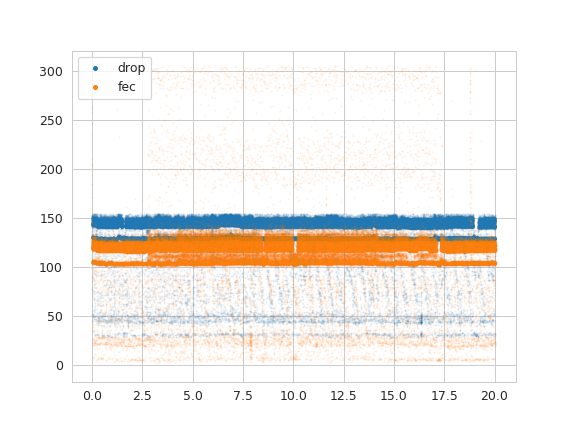

<IPython.core.display.Javascript object>


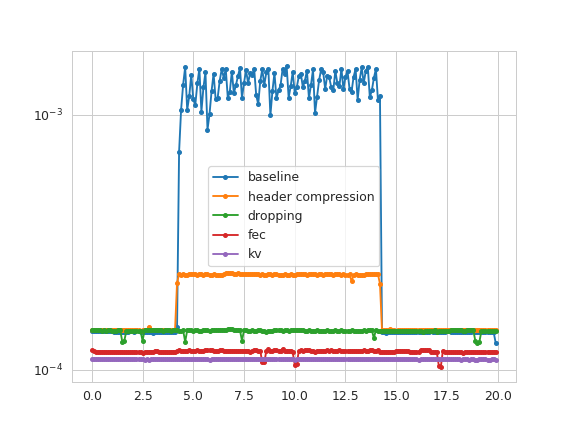

In [577]:
plt.figure()
plot_timeseries(new_drop[0], 'drop')

plot_timeseries(new_fec[0], 'fec')
lgnd = plt.legend()
for h in lgnd.legendHandles:
    h._legmarker.set_markersize(6)
    h._legmarker.set_alpha(1)
    

plt.figure()
plot_rolling_timeseries(new_baseline[0], 'baseline')
plot_rolling_timeseries(new_hc[0], 'header compression')
plot_rolling_timeseries(new_drop[0], 'dropping')
plot_rolling_timeseries(new_fec[0], 'fec')
plot_rolling_timeseries(new_kv[0], 'kv')
plt.yscale('log')
plt.legend()

In [19]:
nobooster

(array([[1.54817584e+09, 2.93016434e-04],
        [1.54817584e+09, 3.41176987e-04],
        [1.54817584e+09, 3.41176987e-04],
        ...,
        [1.54817584e+09, 6.19888306e-05],
        [1.54817584e+09, 6.29425049e-05],
        [1.54817584e+09, 7.48634338e-05]]), 138864, 50000)

In [647]:
%matplotlib notebook
import matplotlib.pyplot as plt

def filter_tds(tds, percentile):
    return tds[tds[:,1] < np.percentile(tds[:,1], percentile)]

def get_rolling_timeseries(tds):
    tds = tds[:]
    tds[:,0] -= min(tds[:,0])
    
    x = []
    y1 = []
    y2 = []
    
    for start in range(0, int(max(tds[:,0]) * 10), 1):
        start /= 10.0
        relevant = tds[(tds[:,0] > start) & (tds[:,0] < start + .1)][:,1]
        x.append(start)
        y1.append(np.median(relevant) * 1e6)
    return x, y1
       
def plot_rolling_timeseries(tds, label=None):
    x, y = get_rolling_timeseries(tds)
#     plt.plot(x, y1, '.-', label=label )
    plt.plot(x, y, '.-', label=label )
    

def plot_timeseries(tds, label=None, gets=None, percentile=99):
    times, diffs = filter_tds(tds, percentile).T
    scaled_times = (times - min(times))# (times - min(times)) / (max(times) - min(times))
    plt.plot(scaled_times, diffs * 1000000, '.', markersize=1, alpha=.1, label=label)
    
def plot_histogram(tds, label):
    times, diffs = filter_tds(tds, 100).T
    diffs *= 1000000
    plt.hist(diffs, alpha=.7, bins=np.arange(100.0)/2 - .25, label=label)

<IPython.core.display.Javascript object>


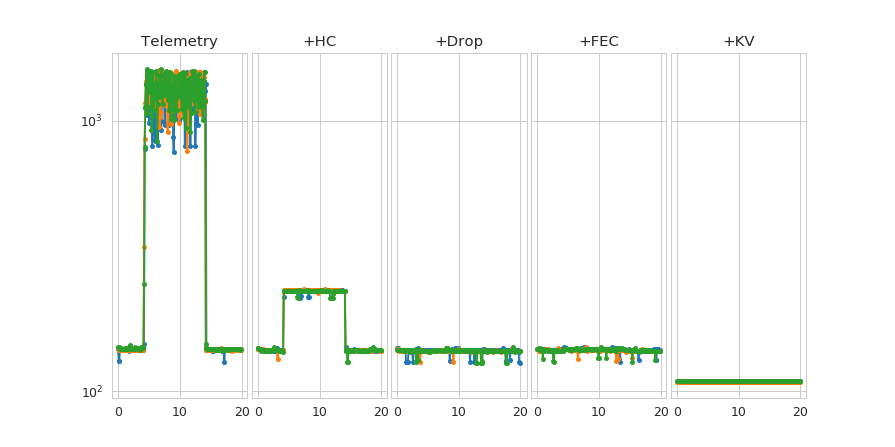

Text(0, 0.5, 'Latency (uS)')

In [664]:

def make_grouped_mcd_ts(groups, labels):
        
    grid = Grid(plt.gcf(), rect=111, nrows_ncols=(1,len(groups)),
            axes_pad=.05, label_mode='L',
            )    
        
#     ax = plt.subplot(1, len(grouped), 1) 
    for i, (ax, group, label) in enumerate(zip(grid,groups, labels)):
#         ax = plt.subplot(1, len(grouped), i+1, sharey=ax)
        plt.sca(ax)
        for td in group:
            plot_rolling_timeseries(td[0])
        ax.set_title(label)
        
plt.figure(figsize=(10,5))
make_grouped_mcd_ts(mcd, mcd_labels)
plt.yscale('log')
plt.ylabel("Latency (uS)")

<IPython.core.display.Javascript object>


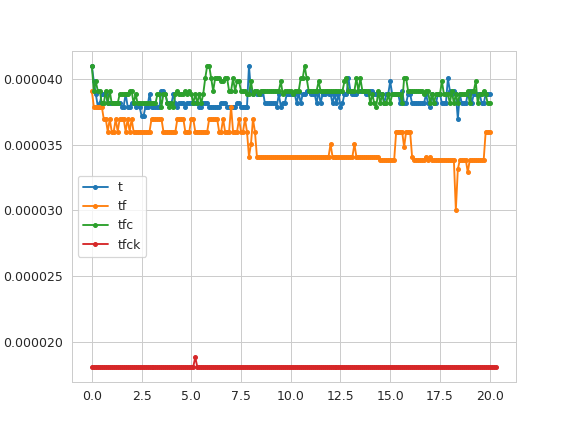

<IPython.core.display.Javascript object>


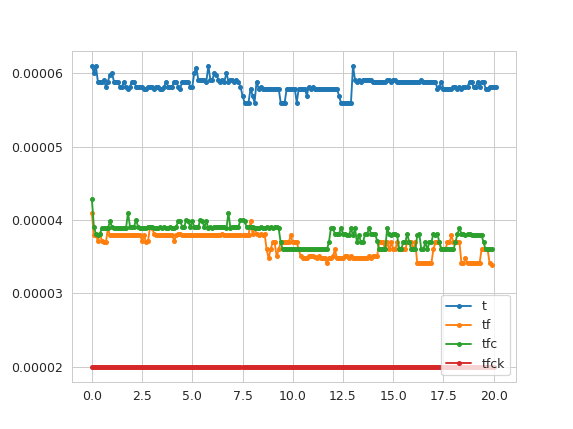

<IPython.core.display.Javascript object>


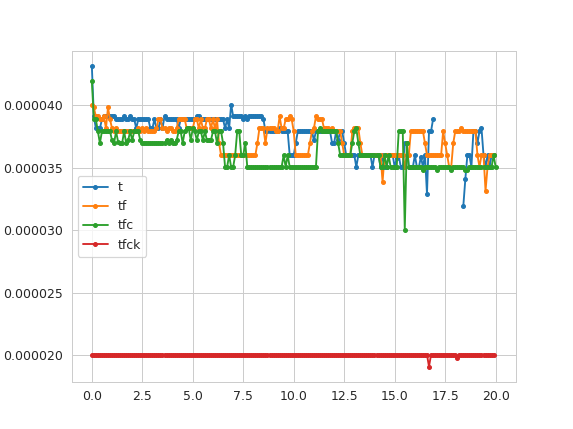

<IPython.core.display.Javascript object>


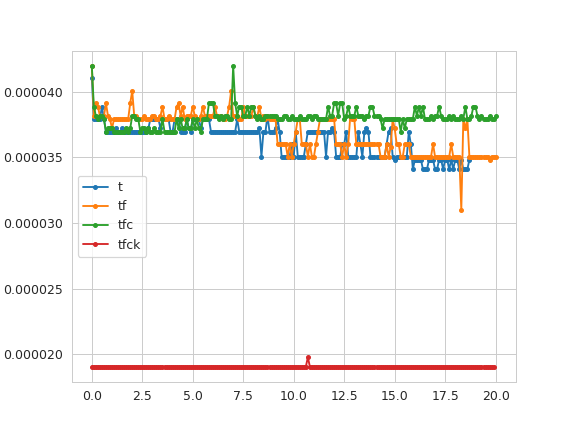

<IPython.core.display.Javascript object>


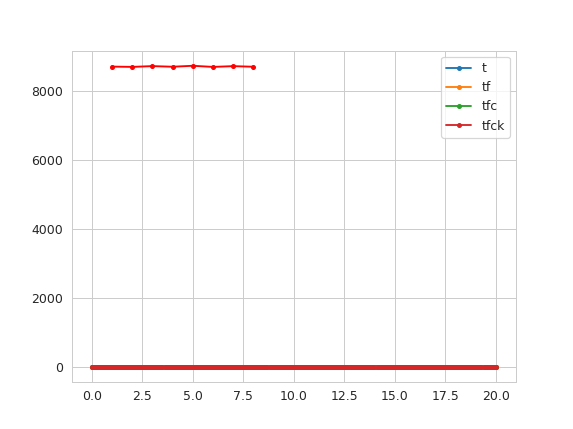

In [536]:
# plt.subplot(1, 2, 1)
# plot_timeseries(tfc_mcd[1][0], 'baseline')
# plt.ylim([0,400])
# plt.title("tfc")
# plt.subplot(1, 2, 2)
# plot_timeseries(tf_mcd[1][0], 'baseline')
# plt.ylim([0,400])
# plt.title('tf')

# plot_timeseries(fec[1][0], 'FEC on')
# plot_timeseries(hc_fec[0][0], "HC and FEC")
# plt.legend()
# plt.figure()
# plot_rolling_timeseries(baseline[0][0], 'baseline')
for i in range(5):
    plt.figure()
    try:
        plot_rolling_timeseries(t_mcd[i][0], 't')
        plot_rolling_timeseries(tf_mcd[i][0], 'tf')
        plot_rolling_timeseries(tfc_mcd[i][0], 'tfc')
        plot_rolling_timeseries(tfck_mcd[i][0], 'tfck')
    except Exception as e:
        print(e)
        continue
        
    plt.legend()

In [534]:
plot_rolling_timeseries(t_mcd[3][0], 't')

IndexError: cannot do a non-empty take from an empty axes.

In [510]:
sum(kv_hc_fec[0][0][:,1] < 25e-6) / len(kv_hc_fec[0][0][:,1])

0.8902992822545701

<IPython.core.display.Javascript object>


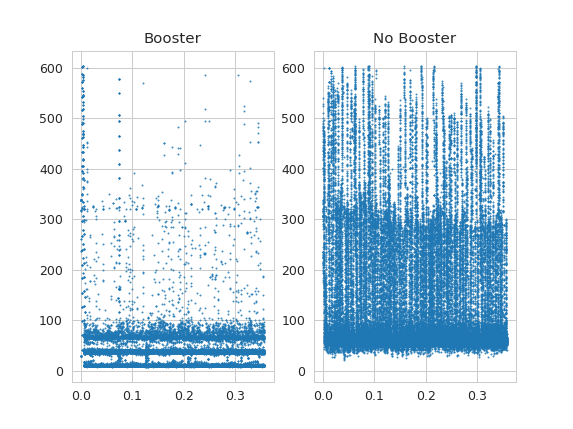

Text(0.5, 1.0, 'No Booster')

In [189]:
ax = plt.subplot(1, 2, 1)
plot_timeseries(booster[0], 'Booster')
plt.title("Booster")
plt.subplot(1, 2, 2, sharey=ax)
plot_timeseries(nobooster[0], 'No booster')
plt.title("No Booster")


In [191]:
sum(booster[0][:,1] < 50e-6) / len(booster[0])

0.8760860276313915

In [106]:
1/ (.35 / 50000)

142857.14285714287

In [195]:
np.median(booster[0][:,1] * 1000000), np.median(nobooster[0][:,1] * 1000000)

(36.95487976074219, 76.05552673339844)

In [609]:
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import sys
import argparse
import os
from collections import defaultdict

DIV=1048576

sns.set_style('whitegrid')

def read_iperf_ts_directory(directory):
    try:
        event_log = json.load(open(os.path.join(directory, 'event_log.json')))
        dp_start = [e for e in event_log if e['name_'] == 'dataplane'][0]
        drop_rate = float(dp_start['drop_rate'])
    except IOError:
        print("{} Event log not found".format(directory))
        return None, None
    
    g = glob(directory + '/iperf/client_*.json')
    if len(g) == 0:
        return None, None
    
    all_points = defaultdict(list)
    
    for file in g:
        try:
            j = json.load(open(file))
        except Exception as e:
            print("Malformed json {}: {}".format(file, e))
            try:
                lines = '\n'.join(open(file).readlines()[1:])
                j = json.loads(lines)
                print("Retry succeeded")
            except Exception as e2:
                print("Retry also failed: {}".format(e2))
                continue
        i=-1
        for i, interval in enumerate(j['intervals']):
            all_points[i].append(interval['sum']['bits_per_second'])
            if all_points[i][-1] / DIV > 5000:
                print(file) 
        if i != 9:
            print("{}: {} intervals".format(file, i+1))
    
    sums = []
    for i in range(len(all_points)):
        sums.append(sum(all_points[i]) / DIV)
        
    return sums
    

def read_directory(directory):
    total_bps = 0
    total_i = 0

    try:
        event_log = json.load(open(os.path.join(directory, 'event_log.json')))
        dp_start = [e for e in event_log if e['name_'] == 'dataplane'][0]
        drop_rate = float(dp_start['drop_rate'])
    except IOError:
        print("{} Event log not found".format(directory))
        return None, None

    g = glob(directory + '/client_*.out')
    if len(g) == 0:
        g = glob(directory + '/iperf/client_*.json')
    if len(g) == 0:
        return None, None

    for file in g:
        try:
            j = json.load(open(file))
            if 'sum_received' in j['end']:
                bps = j['end']['sum_sent']['bits_per_second']
            elif 'sum' in j['end']:
                bps = j['end']['sum']['bits_per_second']
            else:
                raise Exception("No sum or sum_sent")
        except Exception as e:
            print('error', file, e)
            continue
        total_bps += bps
        total_i += 1

    if total_bps == 0:
        return None, None

    print('{}({}): {} Mbps'.format(directory, total_i, total_bps / DIV ))

    return drop_rate, total_bps / DIV

        
def make_iperf_timeseries(folders):
    used_labels=set()
    
    for folder in folders:
        ts = read_iperf_ts_directory(folder['dir'])

        x = np.arange(len(ts))

        label = folder.get('label', None)
        if label not in used_labels:
            used_labels.add(label)
        else:
            label = None
        
        plt.plot(x[1:-1], ts[1:-1], '.-', label=label, color=folder.get('color', None))
    

def make_mean_and_error(vals):
    mean = np.median(vals)
    lowerr = mean - min(vals)
    higherr = max(vals) - mean

    return mean, (lowerr, higherr)

def make_iperf_barplot(fecs, no_fecs, title=None, sv=None):

    fec_by_rate = defaultdict(list)
    nofec_by_rate = defaultdict(list)

    for dir in fecs:
        r, val = read_directory(dir)
        if r is not None:
            fec_by_rate[r].append(val)

    for dir in no_fecs:
        r, val = read_directory(dir)
        if r is not None:
            nofec_by_rate[r].append(val)

    if len(fec_by_rate) != len(nofec_by_rate):
        print("WARNING: {} fec, {} nofec".format(len(fec_by_rate), len(nofec_by_rate)))

    rates, base_vals, base_errs, fec_vals, fec_errs =  \
            [], [], [], [], []

    for rate in sorted(set(fec_by_rate.keys()) | set(nofec_by_rate.keys())):
        
        
        rates.append(rate)

        if rate in fec_by_rate:
            m, e = make_mean_and_error(fec_by_rate[rate])
        else:
            m, e = 0, 0
                
        fec_vals.append(m)
        fec_errs.append(e)

        if rate in nofec_by_rate:
            m, e = make_mean_and_error(nofec_by_rate[rate])
        else:
            m, e = 0, 0

        base_vals.append(m)
        base_errs.append(e)

    x = np.arange(len(rates))
    fig, ax = plt.subplots(figsize=(5,4))

    labels = [str(rate * 100) + "%" for rate in rates]


    #ax.bar(x, base_vals, width=.25, tick_label=labels, label="No FEC")
    ax.bar(x, base_vals, width=.25, yerr=np.array(base_errs).T, tick_label=labels, label="No FEC")
    #ax.bar(x+.3, fec_vals, width=.25, label="FEC")
    ax.bar(x+.3, fec_vals, width=.25, yerr=np.array(fec_errs).T, label="FEC")
    plt.legend()
    ax.set_ylabel("Throughput (Mbps)")
    ax.set_xlabel("Drop rate")

    if title is not None:
        plt.title(title)

    if sv:
        plt.savefig(sv)

    plt.show()


../output/e2e_iperf_fec_compression_.05_3(11): 4451.525462272839 Mbps
../output/e2e_iperf_compression_.05_3(11): 1939.5344663824815 Mbps


<IPython.core.display.Javascript object>


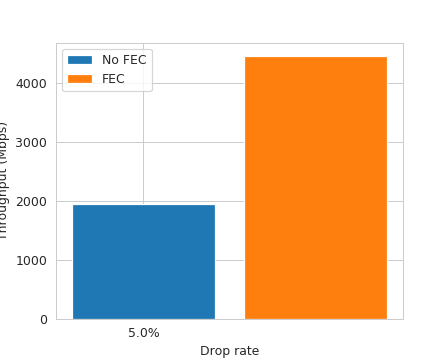

In [497]:
make_mcd_barplot( ['../output/e2e_iperf_fec_compression_.05_3'], ['../output/e2e_iperf_compression_.05_3'])


../output/combined_10(10): 7162.363975386901 Mbps
../output/combined_telemetry_1(10): 6605.990274022341 Mbps


<IPython.core.display.Javascript object>


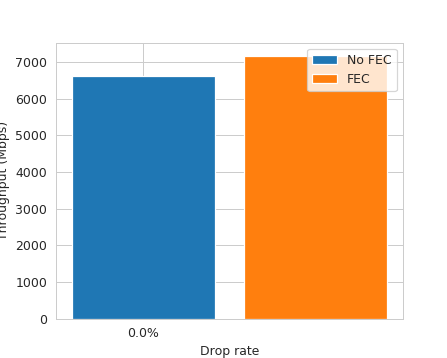

In [498]:
make_iperf_barplot(['../output/combined_10'], ['../output/combined_telemetry_1'])

<IPython.core.display.Javascript object>


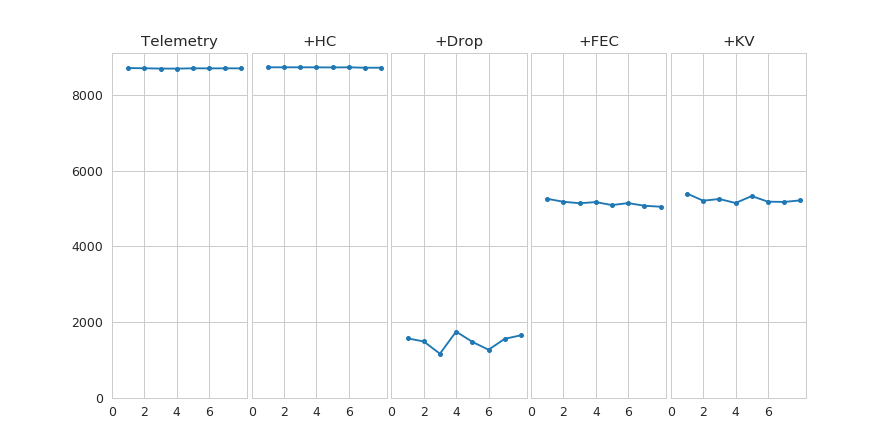

../output_swap/new_tdc_2/iperf/client_6.json: 0 intervals
../output_swap/new_tdc_3/iperf/client_5.json: 0 intervals
../output_swap/new_tdcfk_3/iperf/client_5.json: 0 intervals
Malformed json ../output_swap/new_tdcfk_2/iperf/client_3.json: Expecting value: line 1 column 1 (char 0)
Retry succeeded
../output_swap/new_tdcfk_2/iperf/client_3.json: 9 intervals
[1 2 3 4 5 6 7 8]
[8714.65327634 8709.28296237 8700.46405898 8699.63149984 8707.45977483
 8705.84665434 8707.39139339 8706.2579804 ]
[1 2 3 4 5 6 7 8]
[8734.61515563 8733.54695634 8734.37153353 8733.18793007 8730.90230679
 8733.90890583 8722.9656306  8723.0877453 ]
[1 2 3 4 5 6 7 8]
[1568.87477624 1488.05916421 1163.83203556 1748.8134184  1477.62259896
 1268.39371901 1557.0478383  1650.65479205]
[1 2 3 4 5 6 7 8]
[5258.95791499 5179.68585376 5141.83962303 5170.81977947 5092.88746286
 5145.17351895 5074.36914794 5049.52004511]
[1 2 3 4 5 6 7 8]
[5397.35692733 5208.82470341 5252.89943249 5147.55890435 5330.71676101
 5182.42152384 5175.69

<IPython.core.display.Javascript object>


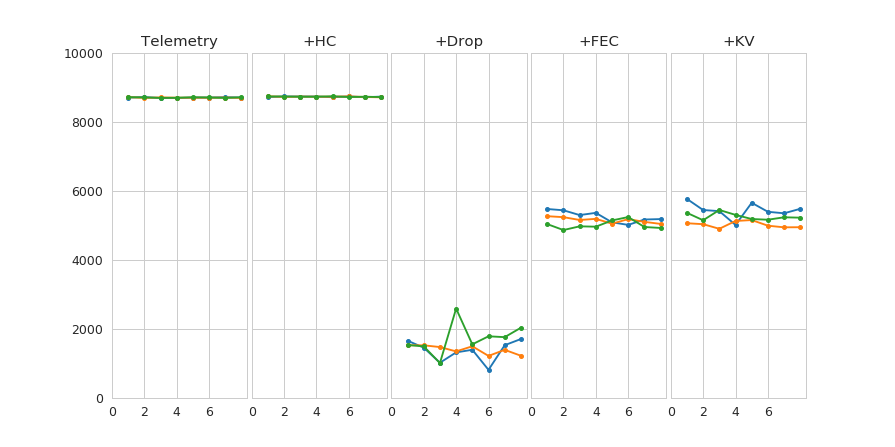

../output_swap/new_tdc_2/iperf/client_6.json: 0 intervals
../output_swap/new_tdc_3/iperf/client_5.json: 0 intervals
../output_swap/new_tdcfk_3/iperf/client_5.json: 0 intervals
Malformed json ../output_swap/new_tdcfk_2/iperf/client_3.json: Expecting value: line 1 column 1 (char 0)
Retry succeeded
../output_swap/new_tdcfk_2/iperf/client_3.json: 9 intervals


Text(0, 0.5, 'Throughput (Mbps)')

In [668]:
from glob import glob
from mpl_toolkits.axes_grid1 import Grid


def make_iperf_dicts(globdir, label):
    ds = []
    for i, dr in enumerate(glob(globdir)):
        d = dict( dir=dr, label=label)
        ds.append(d)
    return ds
        
t = make_iperf_dicts('../output_swap/new_t_*','Telemetry')
td = make_iperf_dicts('../output_swap/new_tc_*','+HC')
tdc = make_iperf_dicts('../output_swap/new_tdc_*', '+Drop')
tdcf = make_iperf_dicts('../output_swap/new_tdcf_*', '+FEC')
tdcfk = make_iperf_dicts('../output_swap/new_tdcfk_*', '+KV')

# plt.figure()
# make_iperf_timeseries(t + tf + tfc + tfck)
# plt.legend()


def group_iperf_timeseries(folders):
    
    grouped = defaultdict(list)
    for folder in folders:
        grouped[folder['label']].append(folder)
        
    grid = Grid(plt.gcf(), rect=111, nrows_ncols=(1,len(grouped)),
            axes_pad=.05, label_mode='L',
            )    
        
#     ax = plt.subplot(1, len(grouped), 1) 
    for i, (ax, (label, tss)) in enumerate(zip(grid, grouped.items())):
#         ax = plt.subplot(1, len(grouped), i+1, sharey=ax)
        plt.sca(ax)
        make_iperf_timeseries(tss)
        ax.set_title(label)
        ax.set_xticks([0,2,4,6])
        

def make_avg_iperf_timeseries(folders):
    
    grouped = defaultdict(list)
    for folder in folders:
        ts = read_iperf_ts_directory(folder['dir'])
        if len(ts) == 10:
            grouped[folder['label']].append(ts)
        
    grid = Grid(plt.gcf(), rect=111, nrows_ncols=(1,len(grouped)),
            axes_pad=.05, label_mode='L',
            )    
        
#     ax = plt.subplot(1, len(grouped), 1) 
    for i, (ax, (label, tss)) in enumerate(zip(grid, grouped.items())):
#         ax = plt.subplot(1, len(grouped), i+1, sharey=ax)
        ts = np.mean(tss, 0)
        x = np.arange(len(ts))
        print(x[1:-1])
        print(ts[1:-1])
        ax.plot(x[1:-1], ts[1:-1], '.-', label=label)
        ax.set_title(label)
        ax.set_xticks([0,2,4,6])
        

plt.figure(figsize=(10, 5))
make_avg_iperf_timeseries(t + td + tdc + tdcf + tdcfk)
plt.ylim([0, None])
plt.ylabel("Throughput (Mbps)")

plt.figure(figsize=(10,5))
group_iperf_timeseries(t + td + tdc + tdcf + tdcfk)
plt.ylim([0, 10000])
plt.ylabel("Throughput (Mbps)")

<IPython.core.display.Javascript object>


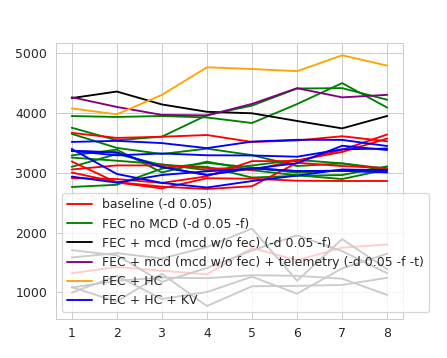

../output_combined/baseline/baseline_3/iperf/client_5.json: 10 intervals
../output_combined/baseline/baseline_3/iperf/client_7.json: 10 intervals
../output_combined/baseline/baseline_3/iperf/client_2.json: 10 intervals
../output_combined/baseline/baseline_3/iperf/client_3.json: 10 intervals
../output_combined/baseline/baseline_3/iperf/client_1.json: 10 intervals
../output_combined/baseline/baseline_3/iperf/client_6.json: 10 intervals
../output_combined/baseline/baseline_3/iperf/client_9.json: 10 intervals
../output_combined/baseline/baseline_3/iperf/client_8.json: 10 intervals
../output_combined/baseline/baseline_3/iperf/client_0.json: 10 intervals
../output_combined/baseline/baseline_3/iperf/client_4.json: 10 intervals
../output_combined/fec_no_mcd/fec_no_mcd_2/iperf/client_5.json: 10 intervals
../output_combined/fec_no_mcd/fec_no_mcd_2/iperf/client_7.json: 10 intervals
../output_combined/fec_no_mcd/fec_no_mcd_2/iperf/client_2.json: 10 intervals
../output_combined/fec_no_mcd/fec_no_mc

In [460]:
make_iperf_timeseries([
    dict(
        label='baseline (-d 0.05)',
        dir='../output_combined/baseline/baseline_3',
        color='r'
    ),
    dict(
        label='FEC no MCD (-d 0.05 -f)',
        dir='../output_combined/fec_no_mcd/fec_no_mcd_2',
        color='g'
    ),
    dict(
        dir='../output_combined/fec_no_mcd/fec_no_mcd_1',
        color='g'
    ),
    dict(
        label='FEC + mcd (mcd w/o fec) (-d 0.05 -f)',
        dir='../output_combined/mcd_isolated_no_telemetry/fec_mcd_isolated_no_telemetry_2',
        color='k'
    ),
    dict(
        label='FEC + mcd (mcd w/o fec) + telemetry (-d 0.05 -f -t)',
        dir='../output_combined/fec_and_telemetry/fec_and_telemetry_1',
        color='purple'
    ),
    dict(
        label='FEC + HC',
        dir='../output_combined/hc_fec_and_telemetry/hc_fec_and_telemetry_1',
        color='orange'
    ),
    dict(
        label='FEC + HC + KV',
        dir='../output_combined_faster/t_f_c_k/t_f_c_k_1',
        color='blue'
    )
])

<IPython.core.display.Javascript object>


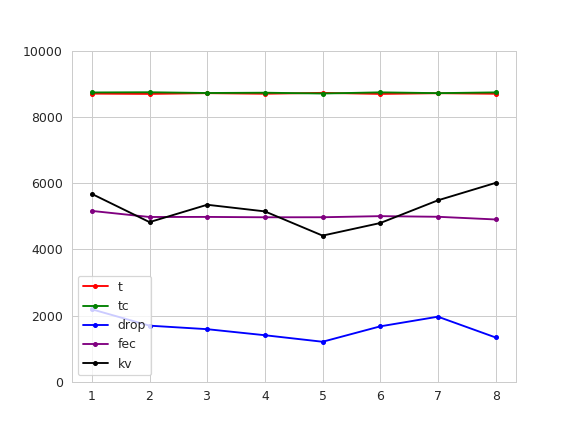

../output_test/test_noflags/iperf/client_5.json: 10 intervals
../output_test/test_noflags/iperf/client_7.json: 10 intervals
../output_test/test_noflags/iperf/client_2.json: 10 intervals
../output_test/test_noflags/iperf/client_3.json: 10 intervals
../output_test/test_noflags/iperf/client_1.json: 10 intervals
../output_test/test_noflags/iperf/client_6.json: 10 intervals
../output_test/test_noflags/iperf/client_9.json: 10 intervals
../output_test/test_noflags/iperf/client_8.json: 10 intervals
../output_test/test_noflags/iperf/client_0.json: 10 intervals
../output_test/test_noflags/iperf/client_4.json: 10 intervals
../output_test/test_hc/iperf/client_5.json: 10 intervals
../output_test/test_hc/iperf/client_7.json: 10 intervals
../output_test/test_hc/iperf/client_2.json: 10 intervals
../output_test/test_hc/iperf/client_3.json: 10 intervals
../output_test/test_hc/iperf/client_1.json: 10 intervals
../output_test/test_hc/iperf/client_6.json: 10 intervals
../output_test/test_hc/iperf/client_9.

In [559]:
plt.figure()
make_iperf_timeseries([
    dict(
        label='t',
        dir='../output_test/test_noflags',
        color='r'
    ),
    dict(
        label='tc',
        dir='../output_test/test_hc',
        color='g'
    ),
    dict(
        label='drop',
        dir='../output_test/test_drop',
        color='b'
    ),
    dict(
        label='fec',
        dir='../output_test/test_fec',
        color='purple'
    ),
    dict(
        label='kv',
        dir='../output_test/test_kv',
        color='k'
    )
])
plt.ylim([0, 10000])
plt.legend()